In [1]:
%load_ext autoreload
%autoreload 2

%autosave 10

#%load_ext lab_black

Autosaving every 10 seconds


In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [3]:
from lfp_analysis.data import *
from lfp_analysis.process import *

In [4]:
import numpy as np
import pandas as pd
import h5py
from scipy import signal


from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib widget

In [5]:
def dB(x): return 20 * np.log10(abs(x))
def zscore(z): return (z-np.mean(z))/np.std(z)

# Frequency response of rwt filter:

In [6]:
b,a = rwt_coefficients(20,2048,6)

a,b = np.array(a),np.array(b)

In [7]:
sys = signal.dlti(b,a,dt=1/2048.0)
w, h = signal.freqz(b,a,fs=2048)


In [8]:
fig, ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(w,h.real); ax[0,1].plot(w,np.abs(h))
ax[1,0].plot(w,h.imag); ax[1,1].plot(w,np.angle(h,deg=True))

ax[0,0].set_title('Real'); ax[0,1].set_title('Abs'); 
ax[1,0].set_title('Imag'); ax[1,1].set_title('Phase'); 

ax[0,0].set_xlim([0, 100])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 100.0)

Text(0.5, 0, 'Frequency [Hz]')

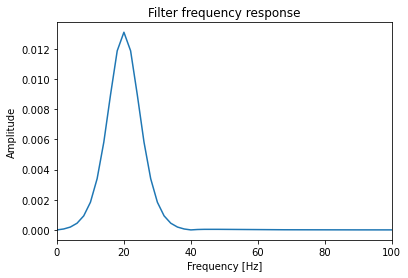

In [9]:
fig, ax = plt.subplots()
ax.plot(w,np.abs(h))

ax.set_title('Filter frequency response')
ax.set_xlim([0, 100])
ax.set_ylabel('Amplitude')
ax.set_xlabel('Frequency [Hz]')

## White noise:

In [10]:
fs = 2048
N = 1e6

raw = np.random.random((1,int(N)))-0.5

In [11]:
f,P = signal.welch(raw,fs=fs,scaling='spectrum')

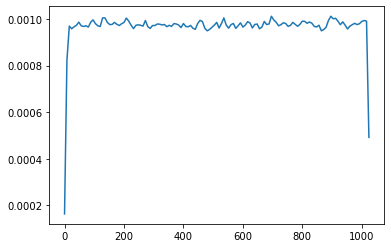

In [12]:
fig,ax = plt.subplots()
ax.plot(f,P.T)

In [13]:
filt_comp = zscore(np.abs(signal.lfilter(b,a,raw)).T)
filt_real = zscore(np.abs(signal.lfilter(np.abs(b),np.abs(a),raw)).T)

diff = filt_comp-filt_real

f,P_comp = signal.welch(filt_comp.T,fs=fs,scaling='spectrum')
f,P_real = signal.welch(filt_real.T,fs=fs,scaling='spectrum')

f,P_diff = signal.welch(diff.T,fs=fs,scaling='spectrum')


(0.0, 100.0)

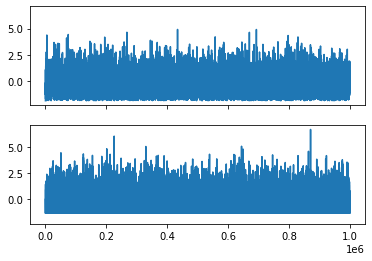

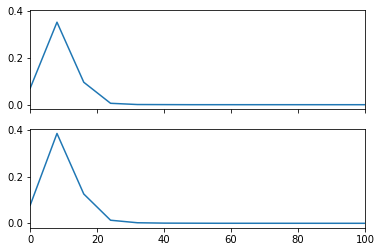

In [14]:
fig, ax = plt.subplots(2,1,sharex=True, sharey=True)
ax[0].plot(filt_comp)
ax[1].plot(filt_real)

fig, ax = plt.subplots(2,1,sharex=True,sharey=True)
ax[0].plot(f,P_comp.T)
ax[1].plot(f,P_real.T)
ax[0].set_xlim([0, 100])

(0.0, 100.0)

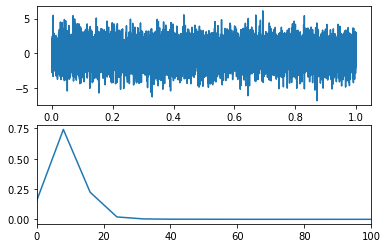

In [15]:
fig, ax = plt.subplots(2,1)

ax[0].plot(diff)
ax[1].plot(f,P_diff.T)
ax[1].set_xlim([0,100])

In [16]:
corr = signal.correlate(filt_comp,filt_real); corr /= np.max(corr)
lags = signal.correlation_lags(filt_comp.size,filt_real.size)

In [17]:
corr.shape

(1999999, 1)

(-5000.0, 5000.0)

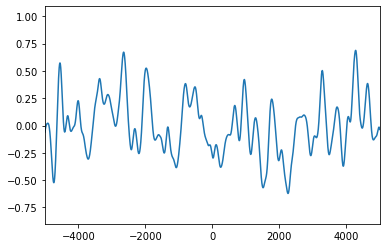

In [18]:
fig, ax = plt.subplots()

ax.plot(lags,corr)
ax.set_xlim([-5000,5000])


# Filterbank and TF-decomposition

Text(0.5, 0, 'Time [s]')

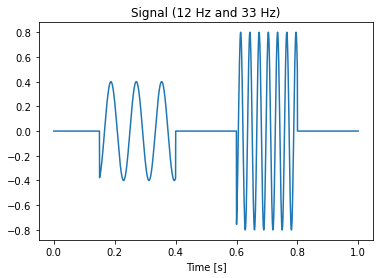

In [19]:
f1 = 12
f2 = 33

t = np.arange(0,1,1.0/fs)
x = 0.4*np.sin(2*np.pi*f1*t)*((t>0.15)&(t<0.4)) + 0.8*np.sin(2*np.pi*f2*t)*((t>0.6)&(t<0.8))
#x = np.sin(2*np.pi*40*t)

fig,ax = plt.subplots()
ax.plot(t,x)
ax.set_title('Signal (12 Hz and 33 Hz)')
ax.set_xlabel('Time [s]')

In [20]:
freqs = [8,12,16,20,24,28,32,36,40,44,48,52,56,60]

b_s,a_s = rwt_filterbank(freqs)

In [21]:
fig,ax = plt.subplots()

for ii,freq in enumerate(freqs):
    w, h = signal.freqz(b_s[ii,],a_s[ii,],fs=2048)
    ax.plot(w,np.abs(h))

ax.set_xlim([-0, 150])
ax.set_xlabel('Freq [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title('RWT filterbank')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'RWT filterbank')

In [22]:
from mne.time_frequency.tfr import morlet

In [23]:
bs_morlet = morlet(2048,freqs,n_cycles=1)

In [24]:
bs_morlet[3].shape

(163,)

In [25]:
fig,ax = plt.subplots()

for ii,freq in enumerate(freqs):
    w, h = signal.freqz(bs_morlet[ii],fs=2048)
    ax.plot(w,np.abs(h))

    ax.set_xlim([0, 150])
    ax.set_xlabel('Freq [Hz]')
    ax.set_ylabel('Amplitude')
    ax.set_title('Morlet filterbank')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
fig,ax = plt.subplots()

for ii,freq in enumerate(freqs[:-1]):
    b,a = signal.butter(2,[freqs[ii], freqs[ii+1]],'bandpass',fs=2048)
    w, h = signal.freqz(b,a,fs=2048)
    ax.plot(w,np.abs(h))

    ax.set_xlim([0, 150])
    ax.set_xlabel('Freq [Hz]')
    ax.set_ylabel('Amplitude')
    ax.set_title('Butterworth filterbank')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
butter = np.zeros((len(freqs)-1,t.size),dtype=np.complex_)

for ii,freq in enumerate(freqs[:-1]):    
    b,a = signal.butter(2,[freqs[ii], freqs[ii+1]],'bandpass',fs=2048)

    butter[ii,:] = np.abs(signal.hilbert(signal.lfilter(b,a,x)))
    
fig,ax = plt.subplots()
ax.imshow(np.abs(butter),extent=[0,1,freqs[0]-2,freqs[-1]+2],origin='lower',aspect='auto',interpolation='none')

ax.vlines(0.15,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.4,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.6,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.8,8,60,colors='w',linestyles='dashed',linewidth=0.5)

ax.hlines(12,0.15,0.4,colors='w');ax.hlines(33,0.6,0.8,colors='w');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Create sinusoid:

In [28]:
rwt = np.zeros((len(freqs),t.size),dtype=np.complex_)

for ii,freq in enumerate(freqs):
    rwt[ii,:] = signal.lfilter(b_s[ii,],a_s[ii,],x)
    
fig,ax = plt.subplots()
ax.imshow(np.abs(rwt),extent=[0,1,freqs[0]-2,freqs[-1]+2],origin='lower',aspect='auto',interpolation='none')

ax.vlines(0.15,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.4,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.6,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.8,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.hlines(12,0.15,0.4,colors='w');ax.hlines(33,0.6,0.8,colors='w');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
cwt = mne.time_frequency.tfr_array_morlet(x[np.newaxis,np.newaxis,...],2048,freqs,n_cycles=3)
cwt = np.squeeze(cwt)

In [30]:
cwt = np.zeros((len(freqs),t.size),dtype=np.complex_)
 
for ii,freq in enumerate(freqs):
    cwt[ii,:] = np.abs(signal.hilbert(np.abs(signal.lfilter(bs_morlet[ii],[1],x))))

In [31]:
fig,ax = plt.subplots()
ax.imshow(np.abs(cwt),extent=[0,1,freqs[0]-2,freqs[-1]+2],origin='lower',aspect='auto',interpolation='none')

ax.vlines(0.15,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.4,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.6,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.8,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.hlines(12,0.15,0.4,colors='w');ax.hlines(33,0.6,0.8,colors='w');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [32]:
cwt = np.zeros((len(freqs),t.size),dtype=np.complex_)

for ii,freq in enumerate(freqs):
    cwt[ii,:] = np.abs(signal.convolve(x,bs_morlet[ii],'same',method='fft'))

fig,ax = plt.subplots()

ax.imshow(np.abs(cwt),extent=[0,1,freqs[0]-2,freqs[-1]+2],origin='lower',aspect='auto',interpolation='none')

ax.vlines(0.15,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.4,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.6,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.vlines(0.8,8,60,colors='w',linestyles='dashed',linewidth=0.5)
ax.hlines(12,0.15,0.4,colors='w');ax.hlines(33,0.6,0.8,colors='w');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …